In [56]:
import requests
import csv

import matplotlib.pyplot as plt
import numpy as np

from colorthief import ColorThief
from sklearn.cluster import KMeans
from skimage import color, io
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

In [25]:
def company_name_to_logo(company_name):
    api_url = 'https://company.clearbit.com/v1/domains/find'
    r = requests.get(api_url, params={'name': company_name}, auth=('sk_10ca0514840dc600a14561a6c518b82b', ''))
    if r.status_code != 200:
        raise Exception(r.status_code)
    logo_url = r.json()['logo']
    
    r = requests.get(logo_url, params={'size': 100})
    if r.status_code != 200:
        raise Exception(r.status_code)
    logo_data = r.content
    
    with open(f'logos/{company_name}.jpg', 'wb') as handler:
        handler.write(logo_data)

In [26]:
def get_colors(filename):
    color_thief = ColorThief(filename)
    palette = color_thief.get_palette(color_count=2)
    return palette

In [46]:
def get_colors_kmeans(filename, nclusters=3):
    rgb_pixels = io.imread(filename)[:,:,:3]
    lab_pixels = color.rgb2lab(rgb_pixels)
    flat_lab_pixels = lab_pixels.reshape(-1, lab_pixels.shape[-1])

    # fit kmeans and get centroids
    kmeans = KMeans(n_clusters = nclusters)
    kmeans = kmeans.fit(flat_lab_pixels)
    centroids = kmeans.cluster_centers_

    # plot
    lab_palette = [convert_color(LabColor(*tuple(c)), sRGBColor) for c in centroids]
    rgb_palette = [(s.rgb_r, s.rgb_g, s.rgb_b) for s in lab_palette]
    return rgb_palette

### Test clearbit logo fetching and palette generation

Some of the logos don't include all of the brand palette colors. Might be good to supplement with something like https://brandpalettes.com. The benefit of this approach is fuzzy text matching (which is unnecessary for database compilation, like in this case, but could be good for something that gives you an approximate palette based on query).

In [47]:
def compare(company_name):
    company_name_to_logo(company_name)
    filename = f"logos/{company_name}.jpg"
    plt.imshow(io.imread(filename))
    plt.figure()
    plt.imshow([get_colors(filename)])
    plt.figure()
    plt.imshow([get_colors_kmeans(filename)])

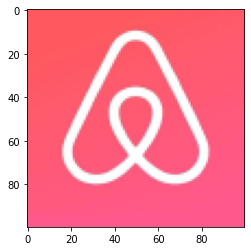

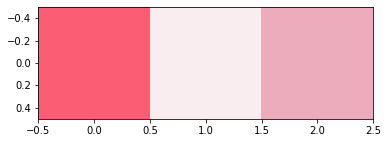

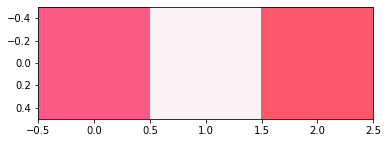

In [48]:
compare("Airbnb")

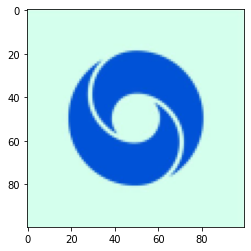

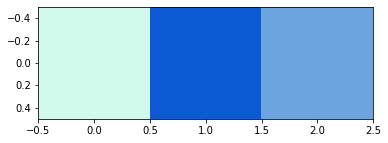

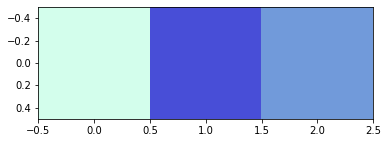

In [29]:
compare("DeepMind")

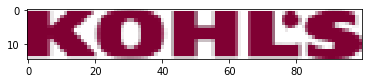

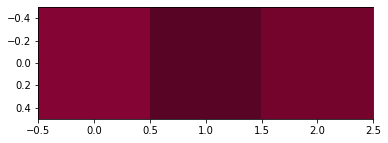

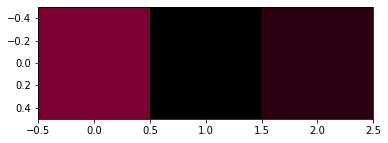

In [30]:
compare("Kohls")

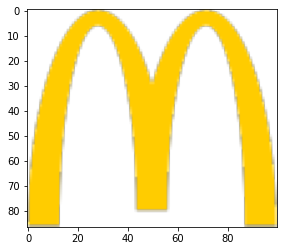

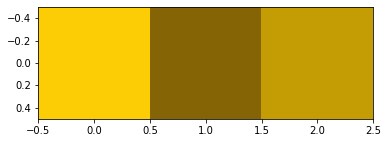

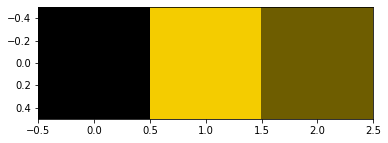

In [31]:
compare("McDonalds")

### Downloading logos and getting palettes of real companies

In [32]:
reader = csv.reader(open('forbes-2000-2018.csv'))
headers = next(reader, None)
forbes_2000_company_names = [row[2] for row in reader]
forbes_2000_company_names[:5]

['360 Security Technology',
 '3M',
 '3i Group',
 '77 Bank',
 'AAC Technologies Holdings']

In [40]:
for company_name in forbes_2000_company_names:
    try:
        company_name_to_logo(company_name)
    except:
        print(f"Skipping {company_name} because 404.")

Skipping Deutsche Lufthansa because 404.
Skipping Deutsche Wohnen because 404.
Skipping Diamondback Energy because 404.
Skipping Digital Realty Trust because 404.
Skipping Discover Financial Services because 404.
Skipping Discovery Communications because 404.
Skipping Dollar General because 404.
Skipping Dominion Resources because 404.
Skipping Don Quijote Holdings because 404.
Skipping Dongfeng Motor Group because 404.
Skipping Dr Pepper Snapple Group because 404.
Skipping E-L Financial because 404.
Skipping E-Trade Financial because 404.
Skipping E.ON because 404.
Skipping E.Sun Financial because 404.
Skipping EMS-Chemie Holding because 404.
Skipping ENN Energy Holdings because 404.
Skipping EXOR because 404.
Skipping East Japan Railway because 404.
Skipping East West Bancorp because 404.
Skipping Ecolab because 404.
Skipping Ecopetrol because 404.
Skipping Edp-energias De Portugal because 404.
Skipping El Puerto de Liverpool because 404.
Skipping Electric Power Development because 4

In [78]:
import os

logo_palettes = {}
for subdir, dirs, files in os.walk('logos'):
    for file in files:
        filepath = subdir + os.sep + file
        company_name = file[:-4]
        logo_palettes[company_name] = get_colors(filepath)

In [92]:
logo_palettes_lab = {}
for k, v in sorted(logo_palettes.items()):
    rgb_v = [sRGBColor(color[0], color[1], color[2], is_upscaled=True) for color in v]
    lab_v = [convert_color(rgb, LabColor) for rgb in rgb_v]
    logo_palettes_lab[k] = [{'L': c.lab_l, 'A': c.lab_a, 'B': c.lab_b} for c in lab_v]

In [94]:
import json

with open('palette/public/logos.json', 'w') as f:
    json.dump(logo_palettes_lab, f)